In [1]:
import copy
#Takes a simplicial complex X (doesn't have to be pure) and returns the dictionary of coefficients for the hyperplanes of the flow polytope.
def coefficient_dictionary(X):
        n = X.dimension()
        my_dict = {}
        for max_face in X.maximal_faces(): #<-- Iterate over maximal faces
            for i in range(max_face.dimension() + 1): #<-- Iterate over indices of the face
                copied_face = list(copy.deepcopy(max_face)) #<--Create a copy of the max face so we can remove elements
                del copied_face[i]
                #Update 3/6/25: changing the sign from (-1)^i to (-1)^(i+1) so that it agrees better with better with flow polytopes from graphs. I think the previous convention was giving essentially "reverse graphs" in the usual flow polytope story.
                my_dict[(tuple(max_face), tuple(copied_face))] = (-1)^(i+1)
        return(my_dict)
    
    
#Takes a simplicial complex X and returns an ordered list of the sub-maximal faces
#Returns list sorted according to lexicographical order
#May need to change this later

def list_of_sub_maximal_faces(X):
    P = X.face_poset()
    return(sorted(list(set([j for i in X.maximal_faces() for j in P.lower_covers(tuple(i)) ]))))

#Takes a simplicial complex X and a netflow vector a_vec and returns the corresponding list of equations needed to define the corresponding flow polytope

def polytope_equation_list(X, a_vec):
    max_faces = sorted(X.maximal_faces()) #<-- Also sorted lexicographically, may need to change later
    n = len(max_faces)
    sub_maximal_faces = list_of_sub_maximal_faces(X)
    m = len(sub_maximal_faces)
    if(len(a_vec) != m):
        print("Vector a must have length equal to the number of sub-maximal faces.")
    else:
        #Inequalities (every variable must be nonnegative)
        mat = matrix.identity(n+1)
        inequalities_list = [mat[i+1] for i in range(n)]
        #Equalities:
        equations_list = []
        coef_dict = coefficient_dictionary(X)
        for i in range(m):
            equations_list.append([-a_vec[i]] + [coef_dict[(tuple(max_faces[j]), tuple(sub_maximal_faces[i]))] if (tuple(max_faces[j]), tuple(sub_maximal_faces[i])) in coef_dict else 0 for j in range(n)])  
        return((equations_list, inequalities_list))
    
#Function that takes a simplicial complex and returns the boundary matrix.
def boundary_matrix(X):
    ls = polytope_equation_list(X, len(list_of_sub_maximal_faces(X))*[0])
    A = matrix(ls[0])
    A = A.delete_columns([0])
    return(A)


#Takes a simplicial complex X and a "netflow vector" a_vec and returns the corresponding flow polytope.
def simplicial_complex_flow_polytope(X, a_vec):
    polytope_data = polytope_equation_list(X, a_vec)
    return(Polyhedron(eqns = polytope_data[0], ieqs = polytope_data[1]))

In [2]:
#Sample Usage:
#Create a Simplicial Complex:

Z = SimplicialComplex([[0,1],[1,2],[0,2],[2,3],[3,4],[2,4],[4,5],[5,6],[4,6]])
Z

#Netflow vectors will be linear combinations of basis vectors from the column space of the boundary matrix of X.
#So we can find some candidate netflow vectors by doing:
A = boundary_matrix(Z)
A.column_space().basis()

#Choosing the sum of all three of the basis vectors gives:
#3-simplex: [-1,-1,2,-1,0,-2]
#0 dimensional for bipyramid: [0,0,0,-1,0,1,0,-1,0]
P = simplicial_complex_flow_polytope(Z, [1,0,0,0,0,0,-1])
P

A 3-dimensional polyhedron in QQ^9 defined as the convex hull of 8 vertices (use the .plot() method to plot)

In [3]:
#The construction of a polyhedron object via its H-representation, requires a precise format. Each inequality 
#(a_i1, ... , a_id) dot x + b_i >= 0 must be written as [b_i,a_i1, ..., a_id].

#Below is using H representation of polytope to write down matrix and build flow polytope for basic 3 vert, 4 edge graph with netflow vector (1,0,-1)

small_graph = Polyhedron(ieqs = [[0, 1, 0,0,0], [0,0,1,0,0], [0,0,0,1,0],[0,0,0,0,1]], eqns = [[-1,1,1,0,0], [0,-1,-1,1,1],[1,0,0,-1,-1]])

alcove = Polyhedron(ieqs = [[0,1,0,0],[0,0,1,0],[0,0,0,1]], eqns = [[-1,1,-1,0],[-1,1,-1,0],[0,0,1,-1],[0,0,1,-1]])

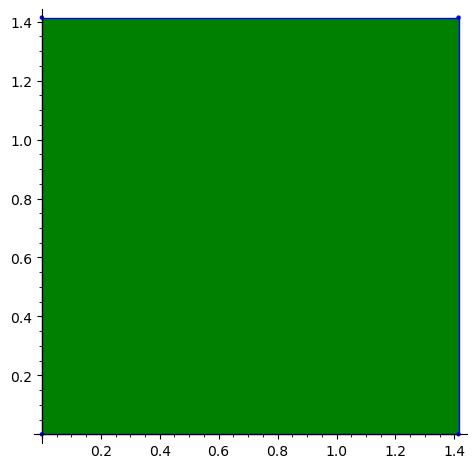

In [5]:
small_graph.plot()

In [6]:
alcove.plot()

Graphics3d Object

In [23]:
medium_graph = Polyhedron(ieqs = [[0,1,0,0,0,0,0], [0,0,1,0,0,0,0], [0,0,0,1,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]], eqns = [[-1,1,1,0,0,0,0], [0,-1,-1,1,1,1,0],[0,0,0,-1,-1,0,1],[1,0,0,0,0,-1,-1]])

alcove_medium = Polyhedron(ieqs = [[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]], eqns = [[-1,1,-1,0,0],[-1,1,-1,0,0],[0,0,1,-1,0],[0,0,1,-1,0],[0,0,1,0,-1],[0,0,0,1,-1]])

In [24]:
medium_graph.plot()

Graphics3d Object

In [10]:
alcove_medium

A 1-dimensional polyhedron in QQ^4 defined as the convex hull of 1 vertex and 1 ray (use the .plot() method to plot)

4/9/25 - Thinking about what it means to be a "cut" polytope

Cuts aren't continuous like flows so it's less obvious what a polytope could represent. Are the vertices the cuts and the interior is convex combinations of them?

Seems like maybe the vertices should be the output b vectors of A^T y = b where y says which vertices are in which half (always put source in group 0, sink in group 1)

In [2]:
At = matrix(ZZ,[[1,-1,0,0],[1,-1,0,0],[0,1,-1,0],[0,1,-1,0],[0,1,0,-1],[0,0,1,-1]])
At

[ 1 -1  0  0]
[ 1 -1  0  0]
[ 0  1 -1  0]
[ 0  1 -1  0]
[ 0  1  0 -1]
[ 0  0  1 -1]

In [6]:
A = At.transpose()

In [10]:
At * vector([0,0,0,1])

(0, 0, 0, 0, -1, -1)

In [4]:
cut = Polyhedron(vertices = [[0,0,0,0,-1,-1],[-1,-1,1,1,0,-1],[-1,-1,0,0,0,0],[0,0,-1,-1,-1,0]])
cut

A 2-dimensional polyhedron in ZZ^6 defined as the convex hull of 4 vertices (use the .plot() method to plot)

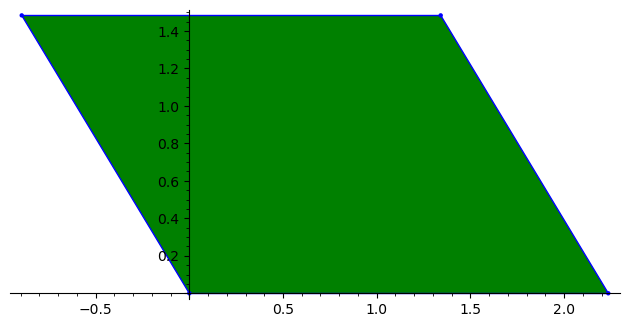

In [5]:
cut.plot()

In [6]:
#supporting hyperplanes defining above
for q in cut.Hrepresentation():
   print(q)

An equation (0, 0, 0, 1, -1, 1) x + 0 == 0
An equation (1, 0, 0, 0, 1, 0) x + 1 == 0
An equation (0, 1, 0, 0, 1, 0) x + 1 == 0
An equation (0, 0, 1, 0, -1, 1) x + 0 == 0
An inequality (0, 0, 0, 0, -1, 0) x + 0 >= 0
An inequality (0, 0, 0, 0, 0, -1) x + 0 >= 0
An inequality (0, 0, 0, 0, 1, 0) x + 1 >= 0
An inequality (0, 0, 0, 0, 0, 1) x + 1 >= 0
